In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pbjam.modeID import modeIDsampler
from pbjam import IO
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from matplotlib.pyplot import *
import astropy.convolution as conv


In [3]:
psd = IO.psd('KIC5184732', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

Using cached search result.
Loading fits files from cache.


In [4]:
psd()

In [5]:
# obs = {'numax': (10**3.34222494336567, 5),
#        'dnu': (10**2.01810676416183, 0.54),
#        'd02': (10**0.68977840189176, 0.54),
#        'teff': (10**3.76117581315573, 142), 
#        'bp_rp': (0.86, 0.05),
#        'p_L0'        : 4e-10, 
#        'p_D0'        : 6e-10, 
#        'DPi0'       : 0.5,  #1/muHz
#        'eps_g'      : 0.75, 
#        'alpha_g'    : 0.02} 

obs = {'numax'  : (2140, 5),
       'dnu'    : (96.00, 0.54),
       'd02'    : (0.90, 0.54),
       'teff'   : (5842, 142), 
       'bp_rp'  : (0.83, 0.05),
       'p_L0'   : 4e-10, 
       'p_D0'   : 6e-10, 
       'DPi0'   : 0.5,  #1/muHz
       'eps_g'  : 0.75, 
       'alpha_g': 0.02} 

priorpath = IO.get_priorpath()

In [39]:
M = modeIDsampler(psd.freq, psd.powerdensity, obs, 7, priorpath=priorpath, Npca=7, PCAdims=14, freq_limits=[1,8500])

In [40]:
fac = max([1, 0.5 / (M.f[1] - M.f[0])])
kernel = conv.Gaussian1DKernel(stddev=np.array(fac))
smoo = conv.convolve(M.s, kernel)

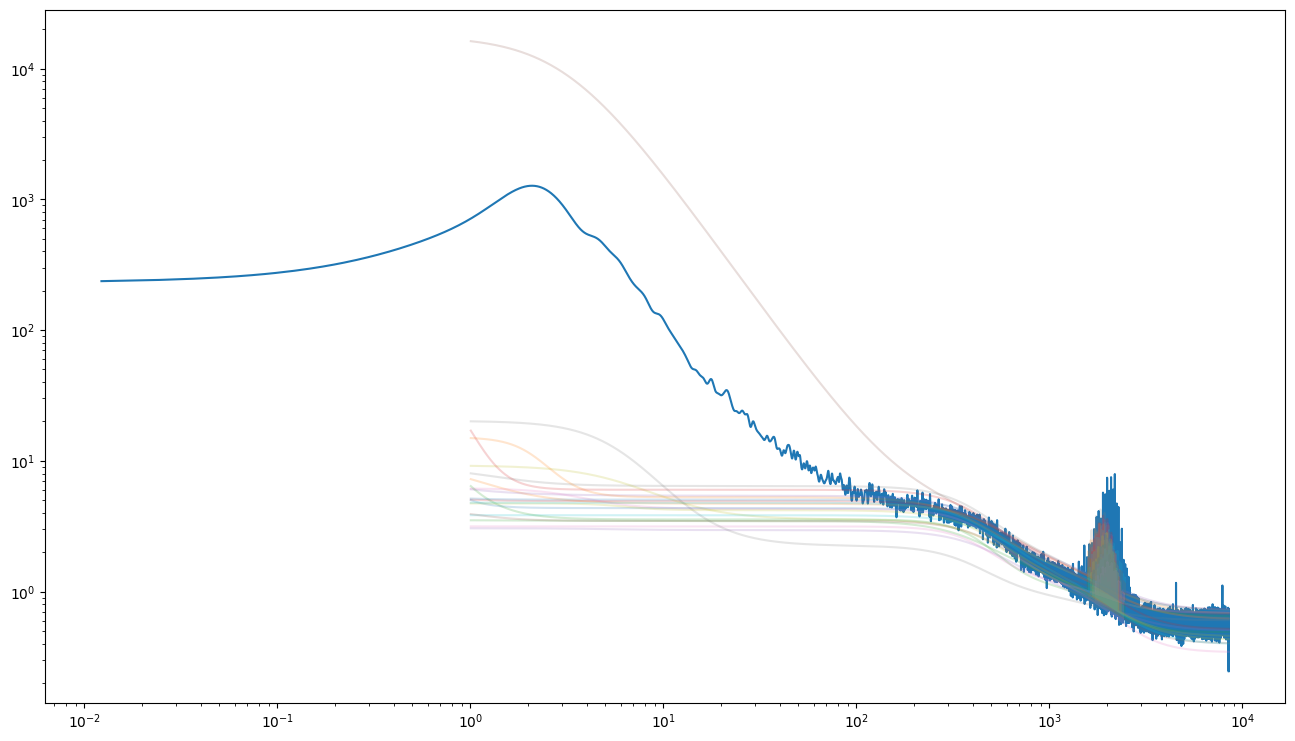

In [45]:
N = 20

fig, ax = subplots(figsize=(16,9))

ax.loglog(M.f, smoo)

for i in range(N):
    u = np.random.uniform(0, 1, size=M.ndims)

    theta = M.ptform(u)

    theta_u = M.unpackParams(theta)

    m = M.model(theta_u, M.f)
    
    ax.loglog(M.f[M.sel], m[M.sel], alpha = 0.2)
    

In [46]:
sampler, samples = M()

3625it [20:22,  2.97it/s, +100 | bound: 215 | nc: 1 | ncall: 152156 | eff(%):  2.450 | loglstar:   -inf < -544654.162 <    inf | logz: -544688.014 +/-  0.551 | dlogz:  0.001 >  0.109]


2011.1743213982922
2011.465628772378
2011.966164223071
2011.1415822346137
2011.1226378123115
2011.59164399504
2010.7509714461864
2010.0807353890673
2010.778320883883
2010.1499089652064


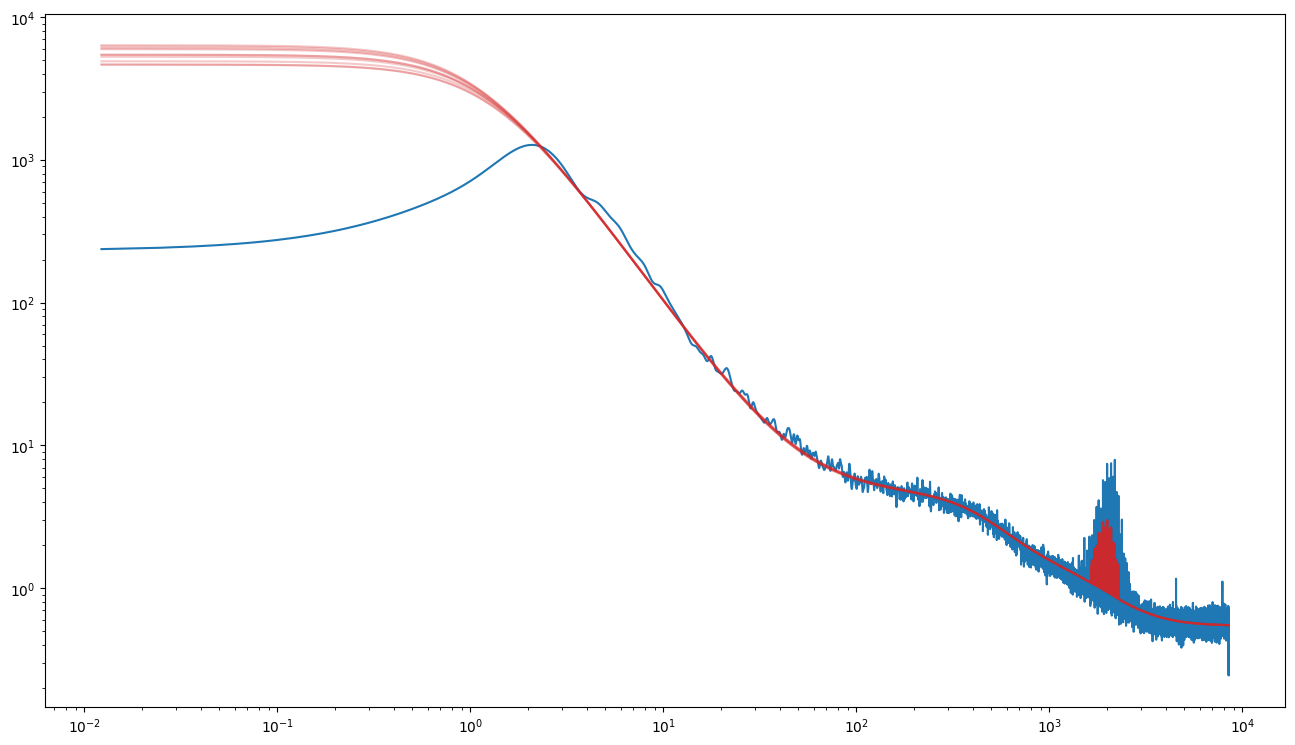

In [48]:
fig, ax = subplots(figsize=(16,9))
ax.plot(M.f, smoo)
#ax.set_xlim(1000, 2500)
#ax.set_ylim(0, 20)
N = 10
for i in np.random.randint(0, samples.shape[0], size=N):
    
    theta = samples[i, :]

    theta_u = M.unpackParams(theta)
    print(theta_u['numax'])
    m = M.model(theta_u, M.f)
    
    ax.plot(M.f, m, color='C3', alpha=0.25)
    
ax.set_yscale('log')
ax.set_xscale('log')

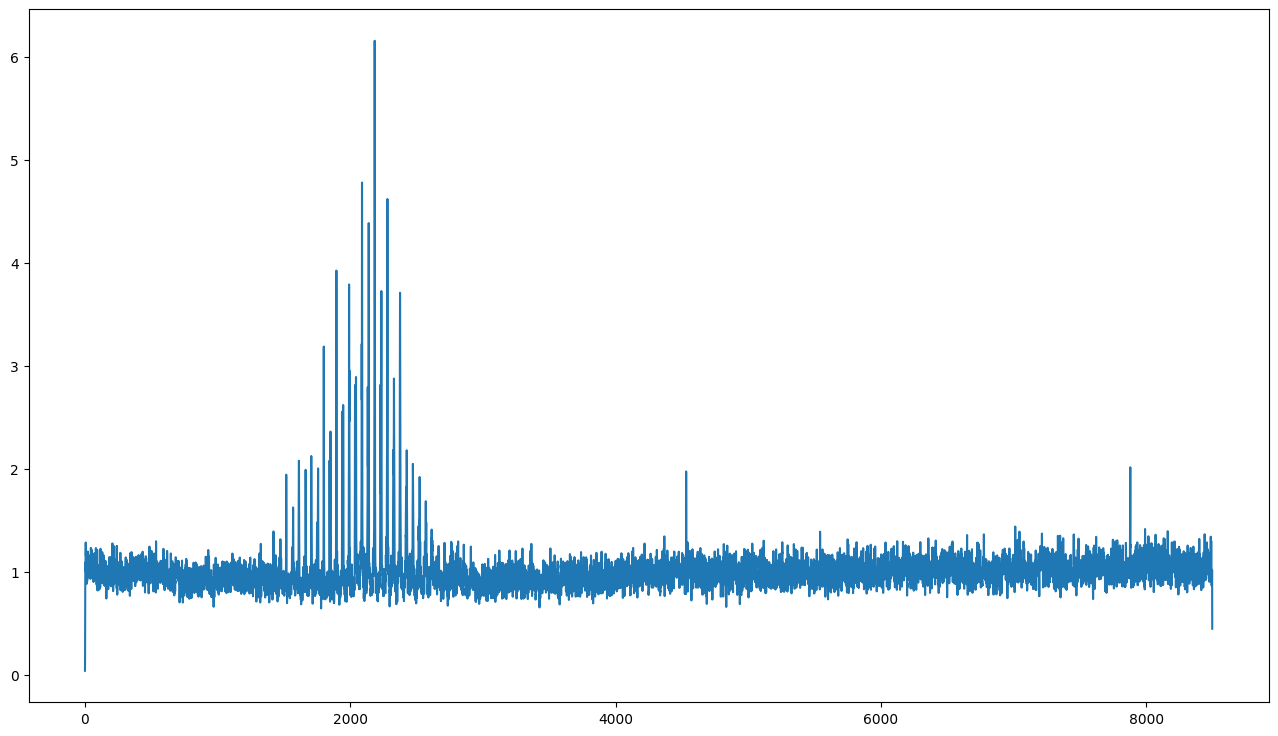

In [49]:
fig, ax = subplots(figsize=(16,9))
ax.plot(M.f, smoo/m)

In [36]:
df = pd.read_csv('pbjam/data/prior_data.csv')

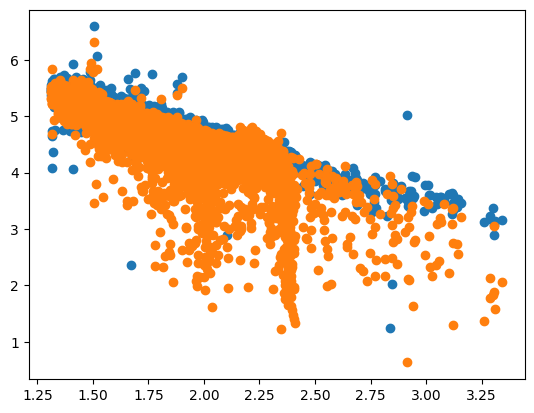

In [43]:
#scatter(np.log10(obs['numax'][0]), np.log10(obs['dnu'][0]), color='C3')
scatter(df['numax'], df['H2_power'], c='C0')
scatter(df['numax'], df['H1_power'], c='C1')

#scatter(M.DR.data_F[:, 1], M.DR.data_F[:, 0], c='C1')
#xlim(3.2, 3.5)
#ylim(1.9, 2.1)

In [ ]:
df['ID'].values[(3.2 < df['numax']) & (df['numax'] < 3.25)]

In [ ]:
key = 'shot'
x = np.linspace(M.priors[key].ppf(1e-3), M.priors[key].ppf(1-1e-3), 100)
fig, ax= subplots()
ax.plot(x, M.priors[key].pdf(x))

In [ ]:
fig = corner.corner(np.array(M.DR.data_R), hist_args={'density': True})
ax = fig.get_axes()
ax = np.array(ax).reshape((M.PCAdims, M.PCAdims))

for i, key in enumerate(list(M.priors.keys())[:M.PCAdims]):
    x = np.linspace(M.priors[key].ppf(1e-3), M.priors[key].ppf(1-1e-3), 100)
    ax[i,i].plot(x, M.priors[key].pdf(x))

In [ ]:
M.PCAdim

In [ ]:
theta_u = M.unpackParams(theta)

In [ ]:
df = pd.read_csv('pbjam/data/prior_data.csv')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(df['H1_exp'], df['H2_exp'], s = 5, alpha=0.5)
#ax.scatter(M.DR.data_F[:, 1], M.DR.data_F[:, 5])

#ax.set_xlim(500,2300)
#ax.set_ylim(0, 7500)
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.scatter(df['numax'], df['H3_power'])

In [ ]:
numax_idx = np.argsort(df['numax'])

In [ ]:
v = df['ID'][numax_idx].values

In [ ]:
v[-10:]

In [ ]:
import matplotlib.pyplot as plt
plt.loglog(M.f, M.model(theta_u, M.f))

In [57]:
S = unpackSamples(M, samples)

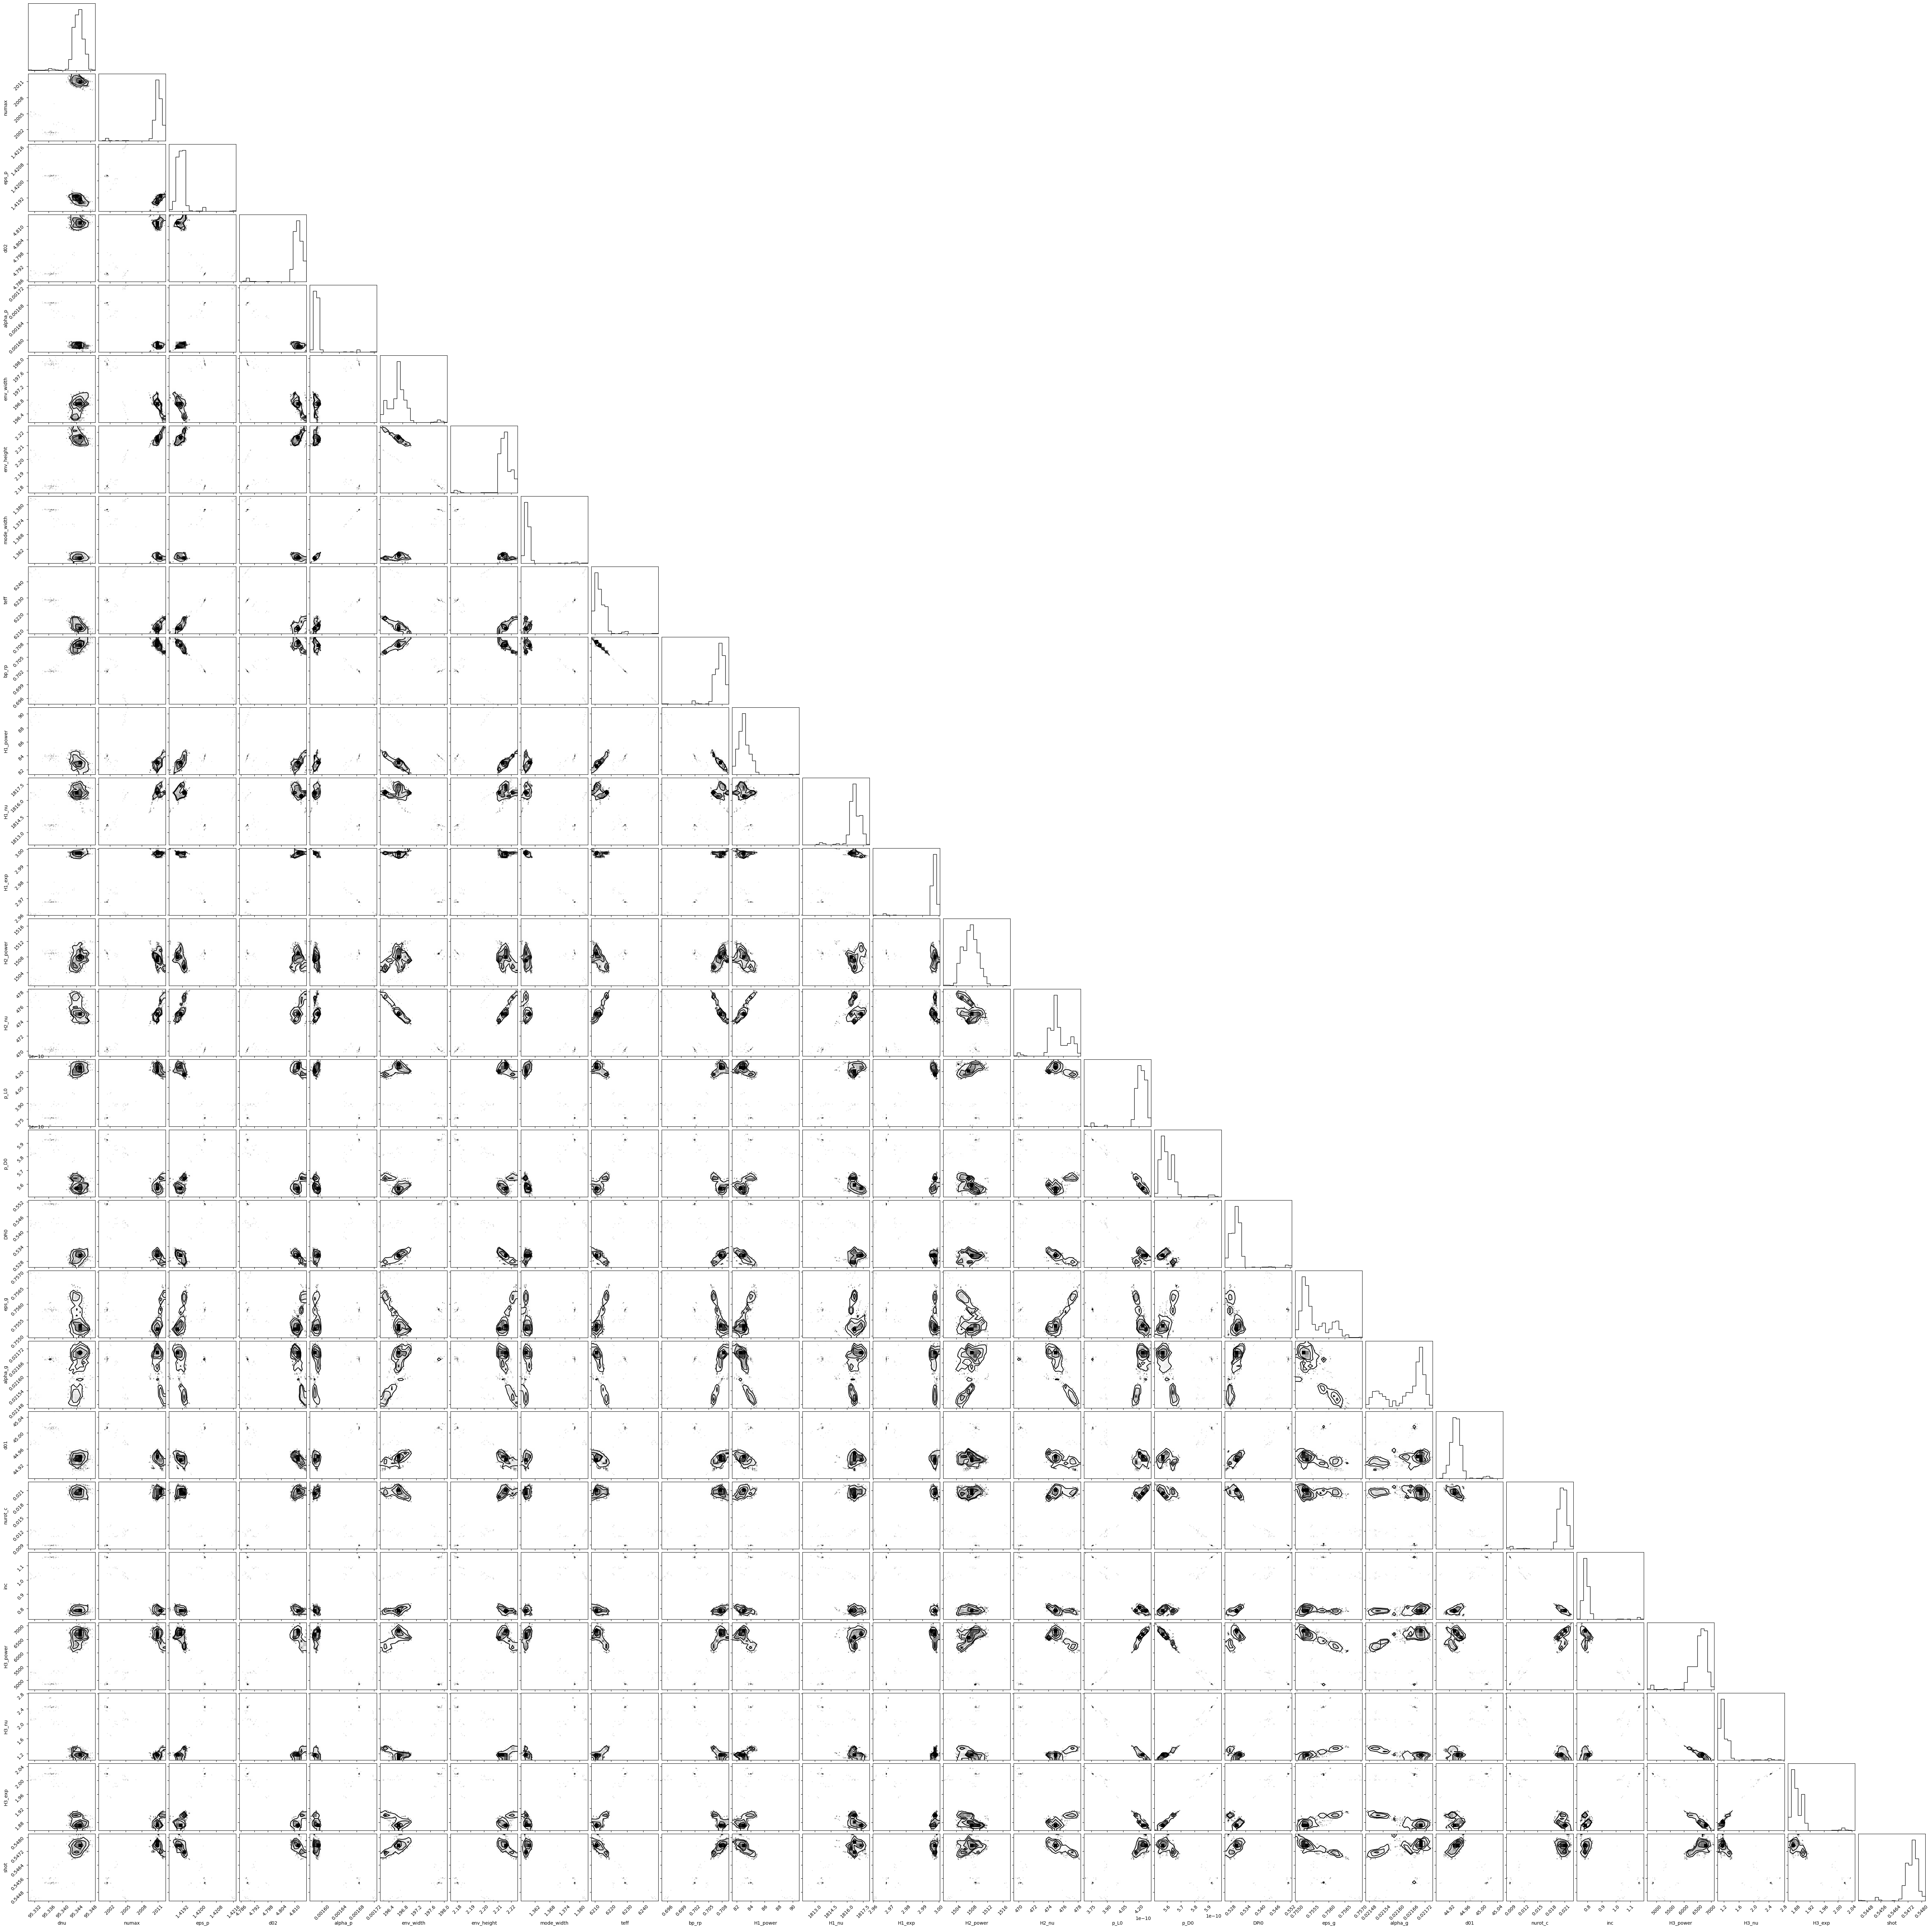

In [63]:
import corner
corner.corner(S);

In [67]:
from pbjam.detection import PEDetection

In [76]:
f, p = psd.freq, psd.powerdensity
 
dilution = 1   

maskPoints = [] # extras.getMaskPoints(ID, artefactListPath)

# PDP_D_122_TEFF_SAPP
Teff = obs['teff'][0]

# PDP_C_125_CLASSICAL_RADIUS.
R = 1.5 # tgtList.loc[k, 'radius']

# Compute the detection flag using the power excess method (MSAP3_01A)
PE = PEDetection(f, p, Teff=Teff, Radius=R, Bin_width=1, dilution=dilution, maskPoints=maskPoints)
PEdetected = PE()

/home/nielsemb/work/repos/PBjam/pbjam/detection.py:607: RuntimeWarning: divide by zero encountered in log10
  muAmax = np.log10(self.env_Amax(nu))
/home/nielsemb/work/repos/PBjam/pbjam/detection.py:618: RuntimeWarning: invalid value encountered in subtract
  self.logProbabilities['wA'][i, :] = np.exp(-(self.Amax[i,:] - muAmax)**2 / (2*self.sigmaAmax**2)) / np.sqrt(2*np.pi*self.sigmaAmax**2)
/home/nielsemb/work/repos/PBjam/pbjam/detection.py:718: RuntimeWarning: overflow encountered in exp
  PH1 = 1 / (1 + np.exp(X) - np.exp(Y))
/home/nielsemb/work/repos/PBjam/pbjam/detection.py:718: RuntimeWarning: invalid value encountered in subtract
  PH1 = 1 / (1 + np.exp(X) - np.exp(Y))
/home/nielsemb/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:1423: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
